In [2]:
!python3 -m pip install keras_applications
import numpy as np 
import random, os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
print(tf.__version__)
import cv2
import keras_vggface

     |████████████████████████████████| 50 kB 172 kB/s eta 0:00:011
2.3.0


In [2]:
PATH = 'Dataset/images'
SIZE = 200
EMB_DIM = 128

In [3]:
def create_batch(batch_size):
    persons = os.listdir(PATH)
    anchors = np.zeros((batch_size, SIZE, SIZE, 3))
    positives = np.zeros((batch_size, SIZE, SIZE, 3))
    negatives = np.zeros((batch_size, SIZE, SIZE, 3)) 

    for i in range(batch_size):
        anc_person_name = persons[random.randint(0,len(persons)-1)]
        anc_person_image_names = os.listdir(PATH + '/' + anc_person_name)
        anc_image_name = anc_person_image_names[random.randint(0,len(anc_person_image_names)-1)]
        anc_image_index = anc_person_image_names.index(anc_image_name)

        pos_image_candidates_names = [name for name in anc_person_image_names if name != anc_person_name] 
        pos_image_name = pos_image_candidates_names[random.randint(0,len(pos_image_candidates_names)-1)]

        neg_candidates = [persons[j] for j in range(len(persons)) if persons[j] != anc_person_name]
        neg_person_name = neg_candidates[random.randint(0,len(neg_candidates)-1)]
        neg_person_image_names = os.listdir(PATH + '/' + neg_person_name)
        neg_image_name = neg_person_image_names[random.randint(0, len(neg_person_image_names)-1)]

        anc = plt.imread(PATH + '/' + anc_person_name + '/' + anc_image_name)
        pos = plt.imread(PATH + '/' + anc_person_name + '/' + pos_image_name)
        neg = plt.imread(PATH + '/' + neg_person_name + '/' + neg_image_name)

        clean_anc = cv2.resize(anc, dsize = (SIZE, SIZE)) / 255.0
        clean_pos = cv2.resize(pos, dsize = (SIZE, SIZE)) / 255.0
        clean_neg = cv2.resize(neg, dsize = (SIZE, SIZE)) / 255.0

        anchors[i] = clean_anc
        positives[i] = clean_pos
        negatives[i] = clean_neg

    return [anchors, positives, negatives]


In [4]:
def plot_triplet(triplet):
    fig, axs = plt.subplots(1,3, figsize = (10,30))
    titles = ['Anchor', 'Positive', 'Negative']
    for i in range(3):
        axs[i].imshow(triplet[i].reshape((SIZE, SIZE, 3)))
        axs[i].set_title(titles[i])
    plt.show()

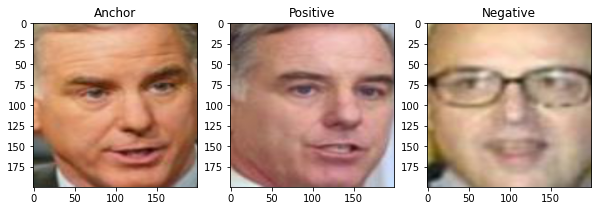

In [5]:
triplet = create_batch(1)
plot_triplet(triplet)

In [6]:
def data_generator(batch_size):
    while True:
        x = create_batch(batch_size)
        y = np.zeros(batch_size)
        yield x, y 

In [7]:
def cosine_similarity(v1, v2):
    dot = v1 * v2
    mod_v1 = tf.sqrt(tf.reduce_sum(tf.square(v1)))
    mod_v2 = tf.sqrt(tf.reduce_sum(tf.square(v2)))
    return dot / (mod_v1 * mod_v2) 

In [8]:
def triplet_loss(alpha = 0.5, emb_dim = EMB_DIM):
    def loss(y_true, y_pred):
        anc, pos, neg = y_pred[:,0:emb_dim], y_pred[:,emb_dim:2*emb_dim], y_pred[:,2*emb_dim:]
        dp = tf.reduce_mean(tf.square(anc - pos), axis = 1)
        dn = tf.reduce_mean(tf.square(anc - neg), axis = 1)
        return tf.maximum(dp - dn + alpha, 0)
    return loss

In [9]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
inception_model = InceptionV3(include_top = False, input_shape = (SIZE, SIZE, 3))
inception_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 99, 99, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 99, 99, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 99, 99, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [10]:
encoder_model = tf.keras.models.Sequential()
encoder_model.add(inception_model)
encoder_model.add(layers.Flatten())
encoder_model.add(layers.Dense(EMB_DIM, activation = 'sigmoid'))
encoder_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 4, 4, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               4194432   
Total params: 25,997,216
Trainable params: 25,962,784
Non-trainable params: 34,432
_________________________________________________________________


In [11]:
# def embedding_model(emb_dim = EMB_DIM):
#     model = tf.keras.models.Sequential([
#         layers.Conv2D(4, (5,5), strides = (1,1), activation= 'relu', input_shape = (SIZE,SIZE,3)),
#         layers.MaxPool2D(pool_size= (4,4), strides = 2),

#         layers.Conv2D(8, (3,3), strides = (1,1), activation= 'relu'),
#         layers.MaxPool2D(pool_size= (3,3), strides = 2),

#         layers.Conv2D(16, (3,3), strides = (1,1), activation= 'relu'),
#         layers.MaxPool2D(pool_size= (2,2), strides = 2),

#         layers.Conv2D(16, (2,2), strides = (1,1), activation= 'relu'),
#         layers.MaxPool2D(pool_size= (2,2), strides = 2),

#         layers.Flatten(),
#         layers.Dense(100,activation='relu'),
#         layers.Dropout(rate = 0.4),
#         layers.Dense(emb_dim,activation='sigmoid')
#     ])
#     return model

In [12]:
# encoder_model = tf.keras.models.load_model('face_encoding_model')

In [13]:
# encoder_model = embedding_model(emb_dim = EMB_DIM)
anc_in = layers.Input(shape = (SIZE,SIZE,3))
pos_in = layers.Input(shape = (SIZE,SIZE,3))
neg_in = layers.Input(shape = (SIZE,SIZE,3))

anc_out = encoder_model(anc_in)
pos_out = encoder_model(pos_in)
neg_out = encoder_model(neg_in)

out = layers.concatenate([anc_out, pos_out, neg_out], axis = 1)
net = Model([anc_in, pos_in, neg_in], out)

In [14]:
encoder_model.summary()
net.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 4, 4, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               4194432   
Total params: 25,997,216
Trainable params: 25,962,784
Non-trainable params: 34,432
_________________________________________________________________
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________

In [15]:
batch_size = 30
epochs = 5
steps_per_epoch = int(6000/batch_size)

In [16]:
previous_loss = 1.0
class StopTrainingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if logs.get('loss') < 0.005:
            self.model.stop_training = True

class SaveModelCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        global previous_loss
        current_loss = logs.get('loss')
        if current_loss < previous_loss:
            previous_loss = current_loss
            try:
                os.remove('face_encoding_model')
            except:
                pass
            encoder_model.save('face_encoding_model')

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(schedule=scheduler)
stop_training_callback = StopTrainingCallback()
save_model_callback = SaveModelCallback()

In [17]:
net.compile(optimizer= tf.keras.optimizers.RMSprop(lr = 0.001), loss = triplet_loss(alpha = 0.5))

In [1]:
history = net.fit(data_generator(batch_size = batch_size), epochs = epochs, steps_per_epoch = steps_per_epoch, callbacks = [stop_training_callback, save_model_callback, lr_schedule])

In [19]:
encoder_model = tf.keras.models.load_model('face_encoding_model')

In [25]:
test_size = 100
triplets = create_batch(test_size)
correct = 0
wrong = 0
for i in range(test_size):
    anc = encoder_model.predict(triplets[0][i].reshape(1,SIZE,SIZE,3))
    pos = encoder_model.predict(triplets[1][i].reshape(1,SIZE,SIZE,3))
    neg = encoder_model.predict(triplets[2][i].reshape(1,SIZE,SIZE,3))
    ap = tf.reduce_mean(tf.square(anc-pos),axis = 1)
    an = tf.reduce_mean(tf.square(anc-neg),axis = 1)
    ap = np.squeeze(ap)
    an = np.squeeze(an)
    flag = (ap < an)
    correct += flag
    wrong += 1 - flag
print(correct / (correct + wrong))

0.83
